## Preparing

In [ ]:
!git init .
!git remote add -f origin "https://github.com/Sankek/ImageInpainting"
!git pull origin master

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# unzipping archive with ~50% of open ImageNet images 
!unzip "/content/drive/MyDrive/Projects/ImageInpainting/dataset/train_jpg.zip" > /dev/null

In [ ]:
# Since Google Colab removed the ability to connect to Google Drive from 
# a non-current account, there is some hack that still allows you to do this.
#
# You need to follow the link that will appear in the output and login to the 
# account that owns the desired Google Drive.
#
# After that, you need to run the next cell.
#
# https://stackoverflow.com/questions/69819761/i-cant-mount-my-another-drive-in-google-colab/70797774#70797774

!sudo add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!sudo apt-get update -qq 2>&1 > /dev/null
!sudo apt -y install -qq google-drive-ocamlfuse 2>&1 > /dev/null
!google-drive-ocamlfuse

In [ ]:
!sudo apt-get install -qq w3m # to act as web browser 
!xdg-settings set default-web-browser w3m.desktop # to set default browser
%cd /content
!mkdir drive
%cd drive
!mkdir MyDrive
%cd ..
%cd ..
!google-drive-ocamlfuse /content/drive/MyDrive
%cd /content

## Go

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader

from tqdm.notebook import tqdm

from data import InpaintingDataset
from models import PConvUNet, VGG16FE
from losses import InpaintingLoss
from utils import save_state, load_state, tensor2image, smooth1d

In [5]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
!nvidia-smi

Sun Jul 17 09:43:45 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
batch_size = 16

dataset_mean = [0.485, 0.456, 0.406] 
dataset_std = [0.229, 0.224, 0.225]

dataset = InpaintingDataset('train_jpg', 256, dataset_mean=dataset_mean, dataset_std=dataset_std)
dataloader = DataLoader(dataset, batch_size=batch_size, pin_memory=True, shuffle=True)

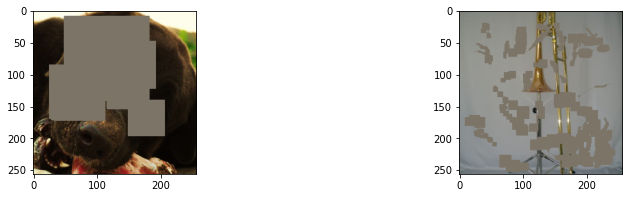

In [ ]:
def plot_examples():
    fig, axs = plt.subplots(1, 2, figsize=(14, 3))
    inp, mask, target = next(iter(dataloader))
    for i in range(2):
        axs[i].imshow(tensor2image(inp[i], dataset_mean, dataset_std))
    plt.show()
plot_examples()

In [9]:
from IPython.display import clear_output


def train_step_graph(test_images, generated_images, gt_test_images, epoch_losses, save_folder='.' 
                     examples_suptitle_text='', losses_suptitle_text='', losses_smooth_window=25):
    num_examples = len(generated_images)
    
    fig, axs = plt.subplots(3, num_examples, figsize=(num_examples*2, 7), squeeze=False)
    for i in range(num_examples):
        axs[0, i].imshow(test_images[i])
        axs[0, i].set_title('Input Image')
        axs[0, i].axis('off')
        axs[1, i].imshow(generated_images[i])
        axs[1, i].set_title('Generated Image')
        axs[1, i].axis('off')
        axs[2, i].imshow(gt_test_images[i])
        axs[2, i].set_title('Ground Truth')
        axs[2, i].axis('off')
    plt.suptitle(examples_suptitle_text)
    fig.tight_layout(pad=2)
    plt.show()

    fig, ax = plt.subplots(figsize=(5, 5))
    ax.plot(smooth1d(np.array(epoch_losses), losses_smooth_window), label='G_losses')
    ax.legend()
    plt.suptitle(losses_suptitle_text)
    plt.show()

def train(model, optimizer, dataloader, criterion, dataset_mean, dataset_std, 
          epochs=1, graph_show_interval=10, losses_smooth_window=25, device='cpu',
          trained_iters=0, save_interval=10000, save_name='baseline'):
    
    inp_test1, mask_test1, target_test1 = dataset[0]
    inp_test2, mask_test2, target_test2 = dataset[1]
    # inp_test = inp_test.unsqueeze(0)
    # mask_test = mask_test.unsqueeze(0)
    # target_test = target_test.unsqueeze(0)
    inp_test = torch.stack([inp_test1, inp_test2])
    mask_test = torch.stack([mask_test1, mask_test2])
    target_test = torch.stack([target_test1, target_test2])
    test_images = [tensor2image(im, dataset_mean, dataset_std) for im in inp_test]
    gt_test_images = [tensor2image(im, dataset_mean, dataset_std) for im in target_test]


    # списки лоссов за все эпохи
    losses = []
    accum_loss_terms = []
    for epoch in range(epochs):
        # списки лоссов за все батчи в эпохе
        epoch_losses = []

        for batch_num, (input, mask, target) in enumerate(dataloader):
            model.train()
    
            input = input.to(device)
            mask = mask.to(device)
            target = target.to(device)
            
            output, _ = model(input, mask)
            loss_terms = criterion(output, mask, target, separate=True)
            loss = sum(loss_terms)
            loss_terms = [term.item() for term in loss_terms]
            accum_loss_terms.append(loss_terms)
            epoch_losses.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            trained_iters += input.shape[0]

            losses_save_interval = batch_size
            if (trained_iters % save_interval) < batch_size:
                save_state(save_folder, f'{save_name}_{trained_iters}', model, optimizer, trained_iters, accum_loss_terms, losses_save_interval)


            # Example images and losses graph 
            # -----------------------------------
            if batch_num % graph_show_interval == 0:
                losses_suptitle_text = f"Epoch: {epoch+1}, {batch_num+1}/{len(dataloader)}"
                examples_suptitle_text = f"loss: {loss:.5f}"

                model.eval()
                with torch.no_grad():
                    genims, _ = model(inp_test.to(device), mask_test.to(device))
                    generated_images = [tensor2image(genim, dataset_mean, dataset_std) for genim in genims]
                
                clear_output(wait=True)
                train_step_graph(
                    test_images, generated_images, gt_test_images, epoch_losses, 
                    examples_suptitle_text, losses_suptitle_text, losses_smooth_window
                )
            # -----------------------------------

        epoch_loss = sum(epoch_losses)/len(dataloader)
        losses.append(epoch_loss)
        
    return losses

In [10]:
lr = 2e-4

# model = PConvUNet().to(DEVICE)
# trained_iters=0
save_folder = '/content/drive/MyDrive/Projects/ImageInpainting/saved'

prev_state = load_state(save_folder, 'baseline_finetune_lr_1e-4_760000')
model = prev_state['model']
model.load_state_dict(prev_state['model_state'])
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# optimizer = prev_state['optimizer']
optimizer.load_state_dict(prev_state['optimizer_state'])
trained_iters = prev_state['trained_iters']

feature_extractor = VGG16FE().to(DEVICE)
criterion = InpaintingLoss(feature_extractor)


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [ ]:
for p in optimizer.param_groups:
    p['lr'] = 1e-4

In [11]:
model.train_encoder_bn = False

## Training

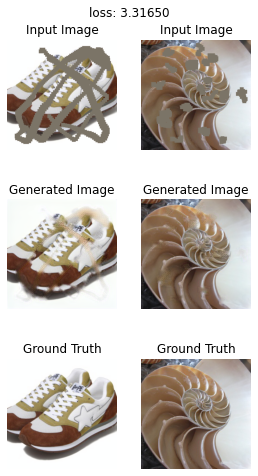

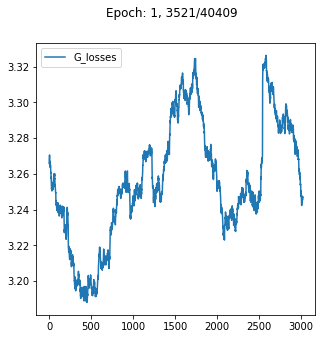

In [ ]:
losses = train(
    model, optimizer, dataloader, criterion, dataset_mean, dataset_std, 
    epochs=1, device=DEVICE, trained_iters=trained_iters, save_folder=save_folder, 
    save_name='baseline_finetune_lr_1e-4', losses_smooth_window=500
)